## Load Wrapper and Verify Interface Supply Voltages

Remember that whenever you power-cycle the Observatory Simulator, you should set `preload=True` below.

When you are running this notbook and it has *not* been power cycled, you should set `preload=False`.

In [1]:
from tessfpe.dhu.fpe import FPE
from tessfpe.dhu.unit_tests import check_house_keeping_voltages
fpe1 = FPE(1, debug=False, preload=True, FPE_Wrapper_version='6.1.1')
print fpe1.version
if check_house_keeping_voltages(fpe1):
    print "Wrapper load complete. Interface voltages OK."

Observatory Simulator Version 1.5c - Aug 31 2015 10:58:39
Wrapper load complete. Interface voltages OK.


## Set trim heater currents and read houskeeping value for them.

In [46]:
#TODO For calibration tests, automate this to get calibration data across the full range of command currents.

In [47]:
fpe1.ops.heater_1_current = 0
fpe1.ops.send()
print fpe1.house_keeping["analogue"]["heater_1_current"]
fpe1.ops.heater_1_current = fpe1.ops.heater_1_current.low
fpe1.ops.send()

1.93286132812


In [48]:
fpe1.ops.heater_2_current = 0
fpe1.ops.send()
print fpe1.house_keeping["analogue"]["heater_2_current"]
fpe1.ops.heater_2_current = fpe1.ops.heater_2_current.low
fpe1.ops.send()

1.01641845703


In [49]:
fpe1.ops.heater_3_current = 0
fpe1.ops.send()
print fpe1.house_keeping["analogue"]["heater_3_current"]
fpe1.ops.heater_3_current = fpe1.ops.heater_3_current.low
fpe1.ops.send()

1.03308105469


## Get housekeeping data for PtRTD channels. 

### Note that for this test, RTD1 through RTD11 are calibration resistors, and RTD12 is a 1000 Ohm Platinum RTD, US Sensor PPG102C1.

In [61]:
for i in range(1,13):
    sensor = "pt1000_sensor_{}".format(i)
    print sensor, ":", fpe1.house_keeping["analogue"][sensor]

pt1000_sensor_1 : -121.365814209
pt1000_sensor_2 : -95.24559021
pt1000_sensor_3 : -61.4562225342
pt1000_sensor_4 : -43.3475494385
pt1000_sensor_5 : -21.9898986816
pt1000_sensor_6 : 3.60893249512
pt1000_sensor_7 : 25.3945922852
pt1000_sensor_8 : 49.2113494873
pt1000_sensor_9 : 51.5770721436
pt1000_sensor_10 : 81.0591125488
pt1000_sensor_11 : 128.416366577
pt1000_sensor_12 : 27.5151824951


### Show calibration reference values and set up to convert to Kelvin for error checks. Then do error checks and return TRUE if they pass.

In [54]:
def celsius_to_kelvin(x):
    """Convert a Celsius temperature value to Kelvin"""
    return x + 273.15


# TODO: Copy me to PyCharm
calibration_values = {
        "pt1000_sensor_1": -127.43,
        "pt1000_sensor_2": -97.40,
        "pt1000_sensor_3": -64.09,
        "pt1000_sensor_4": -46.18,
        "pt1000_sensor_5": -24.95,
        "pt1000_sensor_6": 0.51,
        "pt1000_sensor_7": 22.13,
        "pt1000_sensor_8": 45.16,
        "pt1000_sensor_9": 48.23,
        "pt1000_sensor_10": 77.14,
        "pt1000_sensor_11": 126.14,
        "pt1000_sensor_12": 23.92   # This is an actual sensor measuring room temperature
}

def rtd_ref_check(fpe, tolerance=0.05):
    measured_house_keeping = fpe.house_keeping["analogue"]
    for i in range(1,13):
        k = "pt1000_sensor_{}".format(i)
        measure_kelvin_value = celsius_to_kelvin(measured_house_keeping[k])
        expected_kelvin_value = celsius_to_kelvin(calibration_values[k])
        percent_error = abs(1 - (measure_kelvin_value / expected_kelvin_value))
        assert percent_error < tolerance, \
            "Failed temperature sensor check for {sensor}, percent error: {percent_error}".format(
                sensor=k,
                percent_error=percent_error
            )
    return True

rtd_ref_check(fpe1)

True

In [3]:
from tessfpe.dhu.tests import rtd_ref_check
rtd_ref_check(fpe1)

True

### Plot the errors

In [52]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

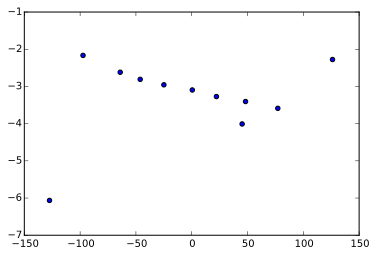

In [53]:
import matplotlib.pyplot as plt
measured_house_keeping = fpe1.house_keeping["analogue"]
x = []
y = []
for i in range(1,12):
    k = "pt1000_sensor_{}".format(i)
    v = calibration_values[k]
    x.append(v)
    y.append(v - measured_house_keeping[k])

plt.scatter(x,y)